# Optimal Dropout Schedules for Two-Layer Networks

In [22]:
import numpy as np
import casadi
from casadi import *
import matplotlib.pyplot as plt
from numpy.random import normal
from tqdm import tqdm
import time
import pickle

## Auxiliary functions

In [23]:
def J2(C):
    c12=C[0][1]
    c11=C[0][0]
    c22=C[1][1]
    return (2/pi)/sqrt(1+c11+c22+c11*c22-c12**2)

def I2(C):
    c12=C[0][1]
    c11=C[0][0]
    c22=C[1][1]
    return asin(c12/(sqrt(1+c11)*sqrt(1+c22)))/pi


def I3(C):
    c12=C[0][1]
    c11=C[0][0]
    c22=C[1][1]
    c13=C[0][2]
    c23=C[1][2]
    c33=C[2][2]

    Lambda3=(1+c11)*(1+c33)-c13**2

    return (2/pi)*(1/sqrt(Lambda3))*(c23*(1+c11)-c12*c13)/(1+c11)

def I4(C):
    c12=C[0][1]
    c11=C[0][0]
    c22=C[1][1]
    c13=C[0][2]
    c23=C[1][2]
    c33=C[2][2]
    c14=C[0][3]
    c24=C[1][3]
    c34=C[2][3]
    c44=C[3][3]

    Lambda4=(1+c11)*(1+c22)-c12**2

    Lambda0=Lambda4*c34-c23*c24*(1+c11)-c13*c14*(1+c22)+c12*c13*c24+c12*c14*c23
    Lambda1=Lambda4*(1+c33)-c23**2*(1+c11)-c13**2*(1+c22)+2*c12*c13*c23
    Lambda2=Lambda4*(1+c44)-c24**2*(1+c11)-c14**2*(1+c22)+2*c12*c14*c24

    return (4/pi**2)*(1/sqrt(Lambda4))*asin(Lambda0/sqrt(Lambda1*Lambda2))
    
def compute_mse(Q,R,T,v,vs,p):
    K,M=R.size()[0],R.size()[1]
    ret=MX(0)
    for i in range(K):
        for j in range(K):
            ret+=0.5*p**2*v[i]*v[j]*I2([[Q[i,i],Q[i,j]],[Q[j,i],Q[j,j]]])


    for n in range(M):
        for m in range(M):
            ret+=0.5*vs[n]*vs[m]*I2([[T[n,n],T[n,m]],[T[m,n],T[m,m]]])

    for i in range(K):
        for n in range(M):
            ret-=p*v[i]*vs[n]*I2([[Q[i,i],R[i,n]],[R[i,n],T[n,n]]])
    return ret
    

In [24]:
K=2 #number of student hidden nodes
M=1 #number of teacher hidden nodes
Q = MX.sym('Q', K, K)  #st-st overlap
R = MX.sym('R', K, M)  #st-th overlap
T = MX.sym('T', M, M)  #th-th overlap
v = MX.sym('v', K)  #student readout weights
vs = MX.sym('vs', M) #teacher readout weights
p= MX.sym('p', 1) #activation probability
mse_sym = compute_mse(Q,R,T,v,vs,p)
mse_func = Function('mse_func', [Q,R,T,v,vs,p], [mse_sym])

In [25]:
#initial conditions
np.random.seed(1974)
N=10000 #input dimension
ws=normal(0,1.,size=(M,N))/np.sqrt(N)
whs=normal(0,1,size=(K,N))/np.sqrt(N)
whs=0*whs
Q0=whs@whs.T
R0=whs@ws.T
T0=ws@ws.T
v0=np.ones(K)
vs=np.ones(M)
p0=0.7
print(mse_func(Q0,R0,T0,v0,vs,p0))

0.084238


In [26]:
alphaF = 5 # Total training time
N_control = 50 # number of control intervals
L=MX(0)
alphas=np.linspace(0,alphaF,N_control+1)

In [27]:
O = MX.sym('O',K*K+K*M+K)
Q, R, v = O[:K*K], O[K*K:K*K+K*M],O[K*K+K*M:]
Q = reshape(Q, K, K)
R = reshape(R, K, M)
r = MX.sym('U',1)


In [28]:
T=np.eye(M) #teacher-teacher overlap
vs=np.ones(M) #
eta,sigma,eta_v=1,0.2,0

In [29]:
dQ=MX.zeros(K,K)
dR=MX.zeros(K,M)
dv=MX.zeros(K)

for i in range(K):
    for n in range(M):
        for m in range(M):
            dR[i,n]+=eta*r*v[i]*vs[m]*I3([[Q[i,i],R[i,n],R[i,m]],[R[i,n],T[n,n],T[n,m]],[R[i,m],T[m,n],T[m,m]]])
        for j in range(K):
            if j!=i:
                dR[i,n]-=eta*r*r*v[i]*v[j]*I3([[Q[i,i],R[i,n],Q[i,j]],[R[i,n],T[n,n],R[j,n]],[Q[i,j],R[j,n],Q[j,j]]])
            else:
                dR[i,n]-=eta*r*v[i]*v[j]*I3([[Q[i,i],R[i,n],Q[i,j]],[R[i,n],T[n,n],R[j,n]],[Q[i,j],R[j,n],Q[j,j]]])
                                    
for i in range(K):
    for k in range(K):
        for m in range(M):
            dQ[i,k]+=eta*r*v[i]*vs[m]*I3([[Q[i,i],Q[i,k],R[i,m]],[Q[i,k],Q[k,k],R[k,m]],[R[i,m],R[k,m],T[m,m]]])
            dQ[i,k]+=eta*r*v[k]*vs[m]*I3([[Q[k,k],Q[k,i],R[k,m]],[Q[i,k],Q[i,i],R[i,m]],[R[k,m],R[i,m],T[m,m]]])
        for j in range(K):
            if j!=i:
                dQ[i,k]-=eta*r*r*v[i]*v[j]*I3([[Q[i,i],Q[i,k],Q[i,j]],[Q[i,k],Q[k,k],Q[k,j]],[Q[i,j],Q[k,j],Q[j,j]]])
            else:
                dQ[i,k]-=eta*r*v[i]*v[j]*I3([[Q[i,i],Q[i,k],Q[i,j]],[Q[i,k],Q[k,k],Q[k,j]],[Q[i,j],Q[k,j],Q[j,j]]])
            if j!=k:
                dQ[i,k]-=eta*r*r*v[k]*v[j]*I3([[Q[k,k],Q[k,i],Q[k,j]],[Q[k,i],Q[i,i],Q[i,j]],[Q[k,j],Q[i,j],Q[j,j]]])
            else:
                dQ[i,k]-=eta*r*v[k]*v[j]*I3([[Q[k,k],Q[k,i],Q[k,j]],[Q[k,i],Q[i,i],Q[i,j]],[Q[k,j],Q[i,j],Q[j,j]]])
                
for i in range(K):
    for k in range(K):
        dQtmp=MX(0)
            
        for n in range(M):
            for m in range(M):
                if i==k:
                    dQtmp+=r*v[i]*v[k]*vs[n]*vs[m]*I4([[Q[i,i],Q[i,k],R[i,n],R[i,m]],[Q[k,i],Q[k,k],R[k,n],R[k,m]],[R[i,n],R[k,n],T[n,n],T[n,m]],[R[i,m],R[k,m],T[m,n],T[m,m]]])
                else:    
                    dQtmp+=r*r*v[i]*v[k]*vs[n]*vs[m]*I4([[Q[i,i],Q[i,k],R[i,n],R[i,m]],[Q[k,i],Q[k,k],R[k,n],R[k,m]],[R[i,n],R[k,n],T[n,n],T[n,m]],[R[i,m],R[k,m],T[m,n],T[m,m]]])
        
        for j in range(K):
            for n in range(M):
                factor=r
                if i!=k:
                    factor=factor*r
                if j!=i and j!=k:
                    factor=factor*r
                dQtmp-=factor*2*v[i]*v[k]*v[j]*vs[n]*I4([[Q[i,i],Q[i,k],Q[i,j],R[i,n]],[Q[k,i],Q[k,k],Q[k,j],R[k,n]],[Q[j,i],Q[j,k],Q[j,j],R[j,n]],[R[i,n],R[k,n],R[j,n],T[n,n]]])

        for j in range(K):
            for l in range(K):
                factor=r
                if i!=k:
                    factor=factor*r
                if j!=i and j!=k:
                    factor=factor*r
                if l!=i and l!=k and l!=j:
                    factor=factor*r
                dQtmp+=factor*v[i]*v[k]*v[j]*v[l]*I4([[Q[i,i],Q[i,k],Q[i,j],Q[i,l]],[Q[k,i],Q[k,k],Q[k,j],Q[k,l]],[Q[j,i],Q[j,k],Q[j,j],Q[j,l]],[Q[i,l],Q[k,l],Q[j,l],Q[l,l]]])
        if i==k:
            dQ[i,k]+=eta**2*r*v[i]*v[k]*sigma**2*J2([[Q[i,i],Q[i,k]],[Q[k,i],Q[k,k]]])
        else:
            dQ[i,k]+=eta**2*r*r*v[i]*v[k]*sigma**2*J2([[Q[i,i],Q[i,k]],[Q[k,i],Q[k,k]]])
        
        dQ[i,k]+=eta**2*dQtmp
        
dQ=0.5*(dQ+dQ.T)


for i in range(K):
    for n in range(M):
        dv[i]+=eta_v*r*vs[n]*I2([[Q[i,i],R[i,n]],[R[i,n],T[n,n]]])
    for j in range(K):
        if j==i:
            dv[i]-=eta_v*r*v[j]*I2([[Q[i,i],Q[i,j]],[Q[i,j],Q[j,j]]])
        else:
            dv[i]-=eta_v*r*r*v[j]*I2([[Q[i,i],Q[i,j]],[Q[i,j],Q[j,j]]])


In [30]:
# Model equations
# Flatten dR and dQ
dQ_flat = reshape(dQ, K * K, 1)  # Column-major order (column by column)
dR_flat = reshape(dR, K * M, 1)  # Column-major order (column by column)

# Concatenate M_flat and Q_flat into a single vector
xdot = vertcat(dQ_flat,dR_flat,dv)

In [31]:
dae = {'x':O, 'p':r, 'ode':xdot, 'quad':L}
F = integrator('F', 'cvodes', dae, 0, alphaF/N_control)

In [32]:
# Evaluate at a test point
Q0flat=Q0.flatten(order='F')
R0flat=R0.flatten(order='F')
O0=np.concatenate((Q0flat, R0flat, v0)).tolist()
p0=np.ones(K)*0.1
Fk = F(x0=O0,p=0.1)
print(Fk['xf'])
print(Fk['qf'])

[0.00237012, 0.000252981, 0.000252981, 0.00237012, 0.00448323, 0.00448323, 1, 1]
0


In [33]:
# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

In [34]:
# "Lift" initial conditions
Ok = MX.sym('O0', K*K+K*M+K)
w += [Ok]
lbw += O0
ubw += O0
w0 += O0
avg_r=0.7
p0=np.ones(K)*avg_r


In [35]:
# Formulate the NLP


for k in range(N_control):
    # New NLP variable for the control
    Uk = MX.sym('U_' + str(k),1)
    w += [Uk]
    lbw += [0 for i in range(1)]
    ubw +=[ 1 for i in range(1)]
    w0 += [avg_r for i in range(1)]
    
    # Integrate till the end of the interval
    Fk = F(x0=Ok, p=Uk)
    Ok_end = Fk['xf']

    # New NLP variable for state at end of interval
    Ok = MX.sym('O_' + str(k+1), K*K+K*M+K)
    w   += [Ok]

    
    
    lbw += [0 if i<K*K else -inf for i in range(K*K+K*M+K)]
    ubw += [inf for i in range(K*K+K*M+K)]
    w0  += O0

     # Add equality constraint
    g   += [Ok_end-Ok]
    lbg += [0 for i in range(K*K+K*M+K)]
    ubg += [0 for i in range(K*K+K*M+K)]

pf = MX.sym('pf',1)

w += [pf]
lbw += [0 for i in range(1)]
ubw +=[ 1 for i in range(1)]
w0 += [avg_r for i in range(1)]


Qf, Rf, vf = Ok[:K*K], Ok[K*K:K*K+K*M], Ok[K*K+K*M:]
Rf = reshape(Rf, K, M)
Qf = reshape(Qf, K, K)
J=compute_mse(Qf,Rf,T,vf,vs,pf)

In [36]:
# Create an NLP solver
prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
solver = nlpsol('solver', 'ipopt', prob)

In [37]:
# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
w_opt = sol['x'].full().flatten()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3150
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2241

Total number of variables............................:      451
                     variables with only lower bounds:      200
                variables with lower and upper bounds:       51
                     variables with only upper bounds:        0
Total number of equality constraints.................:      400
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.6421932e-02 3.02e-02 9.68e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [38]:
Q_opt=[w_opt[i:i+K*K]for i in range(0, len(w_opt), K*K+K*M+K+1)]
R_opt=[w_opt[i:i+K*M]for i in range(K*K, len(w_opt), K*K+K*M+K+1)]
v_opt=[w_opt[i:i+K]for i in range(K*K+K*M, len(w_opt), K*K+K*M+K+1)]
r_opt=[w_opt[i:i+1]for i in range(K*K+K*M+K, len(w_opt), K*K+K*M+K+1)]
p_opt=r_opt[-1]
r_opt=r_opt[:-1]
alphas=np.linspace(0,alphaF,N_control+1)



Rmatrix=[]
Qmatrix=[]
for i in range(len(R_opt)):
    Rmatrix.append(np.reshape(R_opt[i],(K,M),order='F'))
    Qmatrix.append(np.reshape(Q_opt[i],(K,K),order='F'))
Qmatrix_s=[]
Rmatrix_s=[]
Qmatrix_s.append(Qmatrix)
Rmatrix_s.append(Rmatrix)


In [39]:
Rs=[R0flat]
Qs=[Q0flat]
v_s=[v0]
J_const=[float(compute_mse(reshape(Qs[-1], K, K),reshape(Rs[-1], K, M),T,v_s[-1],vs,0.68))]

In [40]:
Js=[]
for i in range(len(R_opt)):
    Js.append(float(compute_mse(reshape(Q_opt[i], K, K),reshape(R_opt[i], K, M),T,v_s[-1],vs,p_opt)))

Text(0, 0.5, 'Activation rate $p(\\alpha)$')

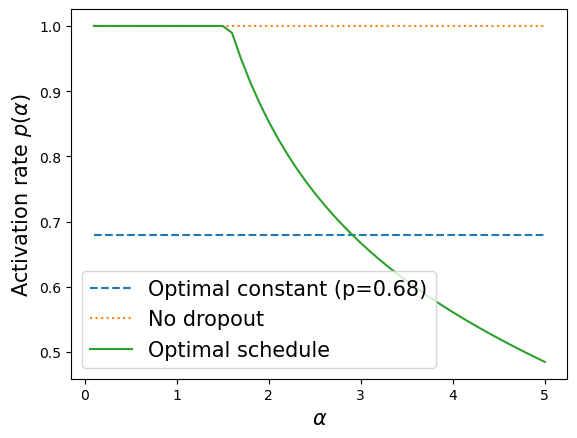

In [41]:
plt.plot(alphas[1:],[0.68 for i in alphas[1:]],linestyle='--',label="Optimal constant (p=0.68)")
plt.plot(alphas[1:],[1 for i in alphas[1:]],linestyle=':',label="No dropout")
plt.plot(alphas[1:],r_opt,label="Optimal schedule")
plt.legend(fontsize=15)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel(r"Activation rate $p(\alpha)$",fontsize=15)